## 2. Convex Regression

### Part A

#### (a) Function using the delayed constraints generation approach

In [1]:
using JuMP, Gurobi, DataFrames, Plots

In [2]:
function convex_regression(X, y, tol, show)
    n, p = size(X)
    status, θ_soln, ξ_soln = 0, 0, 0
    iter = 0
    violation = true # criterion to stop
    I = zeros(n,n) #matrix to contain the indices of the constraints added : 0 if not added, 1 if added
    
    m = Model(solver = GurobiSolver(OutputFlag = 0))
    @variable(m, θ[1:n])
    @variable(m, ξ[1:n, 1:p])
    @variable(m, z)
    a = 0.5   # objective function
    for i = 1:n
        a += (y[i] - θ[i])^2
    end
    @constraint(m, a <= z)
    @objective(m, Min, z)
    
    status = solve(m)
    θ_soln = getvalue(θ)
    ξ_soln = getvalue(ξ)
    
    
    while violation == true
        # build the model
        
        j_matrix, new_j = ones(n, n), convert(Array{Int64,1}, zeros(n))
        violation = false
        for i in 1:n
            for j in 1:n
                j_matrix[i, j] = θ_soln[i] - θ_soln[j] + dot(ξ_soln[i, :], (X[j, :] - X[i, :]) )
            end
            
            temp, ind_temp = findmax(j_matrix[i, :])
            if temp > tol
                violation = true
                new_j[i] = ind_temp
            end
            if new_j[i] != 0
                # update : add constraints to be taken into account
                I[i, new_j[i]] = 1
                @constraint(m, θ[i] + dot(ξ[i,:], (X[new_j[i], :] - X[i, :]) ) <= θ[new_j[i]])
            end
        end
        
    
        a = 0.5   # objective function
        for i = 1:n
            a += (y[i] - θ[i])^2
        end
        @objective(m, Min, z)
        status = solve(m)
        θ_soln = getvalue(θ)
        ξ_soln = getvalue(ξ)
        
        iter +=1
    end
    
    if show
        println("\nStatus: ", status)
        println("Number of iterations: ", iter)
        println("Number of constraints added: ", convert(Int64, sum(I)))
    end
    
    return(θ_soln, ξ_soln, iter, convert(Int64, sum(I)))
end;

---

#### (b) Generate random data X and y

In [3]:
function plot_regression_increase_n(list_n, p)
    tol = 0.1
    list_iter, list_constraints = [], []
    for n in list_n
        X = rand(n, p)
        y = rand(n)
        θ, ξ, iter, constraints = convex_regression(X, y, tol, false);
        push!(list_iter, iter)
        push!(list_constraints, constraints)
    end
    println("list_iter: ", list_iter)
    println("Constraints list : ", list_constraints)
    plot(list_n, [list_iter, list_constraints], seriestype=:scatter, title = "Evolution according to the number of observations", xlabel = "Number of observations", label = ["Number of iterations", "Number of constraints added"])
end;

function plot_regression_increase_p(list_p, n)
    tol = 0.1
    list_iter, list_constraints = [], []
    for p in list_p
        X = rand(n, p)
        y = rand(n)
        θ, ξ, iter, constraints = convex_regression(X, y, tol, false);
        push!(list_iter, iter)
        push!(list_constraints, constraints)
    end
    println("list_iter: ", list_iter)
    println("Constraints list : ", list_constraints)
    plot(list_p, [list_iter, list_constraints], seriestype=:scatter, title = "Evolution according to the number of features", xlabel = "Number of features", label = ["Number of iterations", "Number of constraints added"])
end;

In [4]:
X = rand(25, 5)
y = rand(25)
tol = 0.1
θ, ξ = convex_regression(X, y, tol, true);

Academic license - for non-commercial use only

Status: Optimal
Number of iterations: 8
Number of constraints added: 87


The number of lazy constraints here is 89.
The number of total constraints is $25^2 = 625$.
**So we have only added 14% of the total constraints.**


Let's increase the number of observations and see the impact on the number of constraints added and the number of iterations.

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
list_iter: Any[12, 17, 21, 26, 29, 27, 28, 28, 29, 29]
Constraints list : Any[130, 575, 1205, 1698, 2392, 3157, 3788, 4597, 5517, 6292]


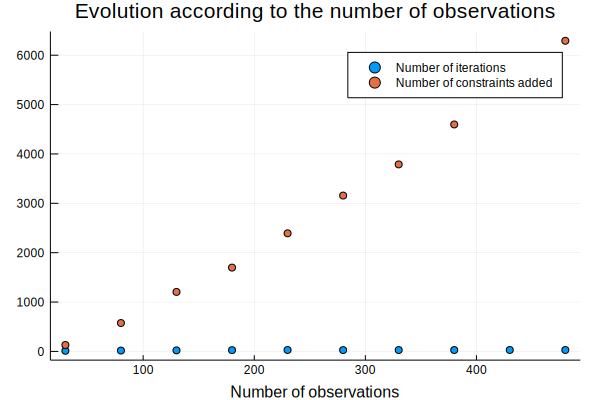

In [16]:
# increase the number of observations
plot_regression_increase_n( [n for n in 30:50:500], 5)

When increasing the number of observations, the number of iterations doesn't change much but the number of constraints added seems to **evolves linearly with the number of observations n**: we have approximately (number of constraints added) $ \approx 10 \times n$.
We should try much higher numbers of n to really know if it's linear or another polynomial dependency, but the number of added constraints would be so great that we couldn't afford to do it with the time we have.

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

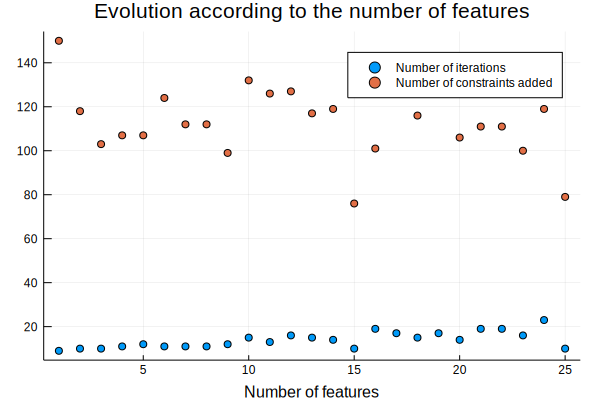

In [18]:
# increase the number of features
plot_regression_increase_p( [p for p in 1:25], 25)

When increasing the number of features without changing the number of observations, both numbers (the number of added constraints and the number of iterations) **don't change much**: $0 \leq number \: of\: iterations \leq 40 $ and $75\leq number\: of\: added \:constraints \leq 160$. So the number of lazy constraints is between $12\% (= 75/(25^2))$ and $25.6 \% (=160/(25^2))$ of the total number of constraints. So in the worst case, we have one fourth of the total number of constraints, which still represent a lot.

---

#### (c) Model predictions

The cutting-plane method with the delayed constraint generation approach uses the approximation of the quadratic function as the maximum of the subdifferentials:

$$y(x) \approx \max_{i=1, ...,m} h_i(x)$$
Where $h_i(x) = \theta_i + \xi_i^T (x_{train,i}-x_i)$, the tangents found.

In [4]:
function model_predictions(θ, ξ, X, X_train)
    n, p = size(X)
    n_orig = length(θ)    
    y_pred = []
    
    for j = 1:n
        each_predict = []
        for i = 1:n_orig
            push!(each_predict, θ[i] + dot(ξ[i, :], (X[j, :] - X_train[i, :])) )
        end
        push!(y_pred, findmax(each_predict)[1])
    end
    return(y_pred)
end;

There is a difference between the predictions and the optimal value of $\theta$. 

Indeed, the optimal value of $\theta$ satisfy all the convexity constraints added, so the the $\theta_i$ are below the curve of the convex function or above it just by a value $tol$. 

However, these model predictions on the training set $X$ will look at the maximum value among all the tangents found based on the values of $\theta$, so the predictions can actually be above the curve by more than $tol$ if this maximum is found on a tangent where there is a greater $\theta$. 

Therefore, the prediction gets worse and the $tol$ increases: as $tol$ increases, the difference between $\theta$ and theses model predictions on $X$ increases.


---

#### (d) Concave regression problem

f is concave if and only if -f is convex.

So, to find the best concave function that predicts $y_i$ as a function of $x_i$, we need to :
- in the function `convex_regression`: multiply `y` by $-1$.
- in the function `model_predictions`: we won't change anything in the input. We simply need to take the given result and multply if by $-1$.

---

---

### Part B

Let's first load the dataset, separate it into training and testing sets, and normalize both sets.

In [5]:
# import dataset
df = readtable("15095_kc_house_data.csv", header=true)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at .\deprecated.jl:70
 [2] #readtable#232(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at C:\Users\utilisateur\.julia\v0.6\DataFrames\src\deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at .\<missing>:0
 [4] include_string(::String, ::String) at .\loading.jl:522
 [5] include_string(::Module, ::String, ::String) at C:\Users\utilisateur\.julia\v0.6\Compat\src\Compat.jl:88
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\utilisateur\.julia\v0.6\IJulia\src\execute_request.jl:180
 [7] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at C:\Users\utilisateur\.julia\v0.6\Compat\src\Compat.jl:332
 [8] eventloop(::ZMQ.Sock

,price,sqft_living,waterfront,view,condition,grade,lat,long
1,221900.0,1180,0,0,3,7,47.5112,-122.257
2,538000.0,2570,0,0,3,7,47.721,-122.319
3,180000.0,770,0,0,3,6,47.7379,-122.233
4,604000.0,1960,0,0,5,7,47.5208,-122.393
5,510000.0,1680,0,0,3,8,47.6168,-122.045
6,1.225e6,5420,0,0,3,11,47.6561,-122.005
7,257500.0,1715,0,0,3,7,47.3097,-122.327
8,291850.0,1060,0,0,3,7,47.4095,-122.315
9,229500.0,1780,0,0,3,7,47.5123,-122.337
10,323000.0,1890,0,0,3,7,47.3684,-122.031


In [6]:
function separate_dataset(dataset, training_size, show)
    X, y = Matrix(dataset[:,2:end]), dataset[:,1]    
    X_train, y_train = X[1:training_size, :], y[1:training_size]
    X_test, y_test= X[training_size+1:end, :], y[training_size+1:end]
    if show==true
        #See the size of training, validation and testing sets
        println("\nSize of training set:",size(X_train),size(y_train))
        println("Size of test set:",size(X_test),size(y_test))
    end
    
    return(X_train,y_train, X_test, y_test)
end;


function normalize(dataset, training_size, show)
    X_train, y_train, X_test, y_test = separate_dataset(dataset, training_size, show)
    p = size(X_train, 2)
    # determine centering and scaling factors
    mean_X_train, mean_y_train = mean(X_train,1), mean(y_train)
    X_train = X_train .- mean_X_train;
    denom_X_train = zeros(p);
    for i in 1:p
      denom_X_train[i] = std(X_train[:,i]);
    end

    # center and scale the datasets
    X_train = X_train ./ denom_X_train';
    X_test = (X_test .- mean_X_train)./denom_X_train'
    denom_y_train = std(y_train)
    y_train = (y_train .- mean_y_train)./denom_y_train
    y_test = (y_test .- mean_y_train)./denom_y_train
    println(std(X_train[:,1]))
    println(std(X_test[:,1]))
    println(std(y_test))
    println(std(y_train))
    
    return(X_train, y_train, X_test, y_test, denom_X_train, mean_X_train, denom_y_train, mean_y_train)
end;    

In [7]:
# use the first 50 rows as the training set
X_train, y_train, X_test, y_test, denom_X_train, mean_X_train, denom_y_train, mean_y_train = normalize(df, 50, true);


Size of training set:(50, 7)(50,)
Size of test set:(950, 7)(950,)
0.9999999999999999
0.9800523408367752
1.0306876079524465
1.0000000000000002


---

#### (a) Fit a concave regression model to predict the prices

In [8]:
function out_of_sample(X_train, y_train, X_test, y_test, θ, ξ)    
    R2_train = 1 - sum((-θ - y_train).^2) / sum((mean(y_train) - y_train).^2)
    
    y_hat_test = -model_predictions(θ, ξ, X_test, X_train)
    R2_test = 1 - sum((y_hat_test - y_test).^2) / sum((mean(y_train) - y_test).^2)
    println("\n***RESULTS***")
    println("R2 train:\t", R2_train)
    println("R2 test:\t", R2_test)
end;

In [9]:
tol = 0.1
θ1, ξ1, iter, constraints = convex_regression(X_train, -y_train, tol, true);

Academic license - for non-commercial use only

Status: Optimal
Number of iterations: 16
Number of constraints added: 438


In [10]:
out_of_sample(X_train, y_train, X_test, y_test, θ1, ξ1)


***RESULTS***
R2 train:	0.9725451652451476
R2 test:	-6.128369274935689e7


**$R^2$ is positive for the training set (normal since we fit the model to the training set), and negative for testing set. So, the model is overfitting. The main reason is because the training set size is much smaller than the testing set size. It should be the opposite.**

**Let's try to switch the sizes, to see if it improves the $R^2$ values:**

In [12]:
# let the first 950 first rows be the training set and the remaining rows be the testing set
X_train, y_train, X_test, y_test, denom_X_train, mean_X_train, denom_y_train, mean_y_train = normalize(df, 950, true);
tol = 0.1
θ1, ξ1, iter, constraints = convex_regression(X_train, -y_train, tol, true);
out_of_sample(X_train, y_train, X_test, y_test, θ1, ξ1)


Size of training set:(950, 7)(950,)
Size of test set:(50, 7)(50,)
0.9999999999999998
0.7126064065503409
0.5172953201966842
0.9999999999999994
Academic license - for non-commercial use only

Status: Optimal
Number of iterations: 35
Number of constraints added: 19376

***RESULTS***
R2 train:	0.8586497228503208
R2 test:	-1.9773490452093184e7


The $R^2$ better for the testing set, but is still negative. So, the model is still overfitting.

Another reason for this might be multicollinearity: some features, such as latitude and square feet, can be colinear, so might give bias

---

#### (b) Fit a new concave regression model to predict price, using only the variable "sqrt_living"

In [11]:
# extract first and second columns : price and sqft_living
df2 = df[1:2];

In [12]:
# fitting and predictions 
X_train2, y_train2, X_test2, y_test2, denom_X_train2, mean_X_train2, denom_y_train2, mean_y_train2 = normalize(df2, 50, true);
tol = 0.1
θ2, ξ2, iter, constraints = convex_regression(X_train2, -y_train2, tol, true);
out_of_sample(X_train2, y_train2, X_test2, y_test2, θ2, ξ2);


Size of training set:(50, 1)(50,)
Size of test set:(950, 1)(950,)
0.9999999999999999
0.9800523408367752
1.0306876079524465
1.0000000000000002
Academic license - for non-commercial use only

Status: Optimal
Number of iterations: 17
Number of constraints added: 649

***RESULTS***
R2 train:	0.44934157006787157
R2 test:	0.4053492618835858


In [13]:
# retrieve square feet between 0 and 5000
temp = [x for x in X_test2 if x*denom_X_train2[1]+mean_X_train2[1]>=0 && x*denom_X_train2[1]+mean_X_train2[1]<=5000]
new_X_test2 = zeros(Float64, length(temp), 1)
for i in 1:length(temp)
    new_X_test2[i] = temp[i]
end

In [16]:
function plot_prediction(X_train, X_test, y_test, denom_X_train, mean_X_train, denom_y_train, mean_y_train, θ, ξ, title, xlabel)
    y_hat_test = -model_predictions(θ, ξ, X_test, X_train)
    
    X_test_orig = X_test .* denom_X_train[1] .+ mean_X_train[1]
    y_hat_test_orig = y_hat_test .* denom_y_train .+ mean_y_train
    plot(X_test_orig, y_hat_test_orig, seriestype=:scatter, title = title, xlabel = xlabel, ylabel = "Predicted prices", leg=false)
end;

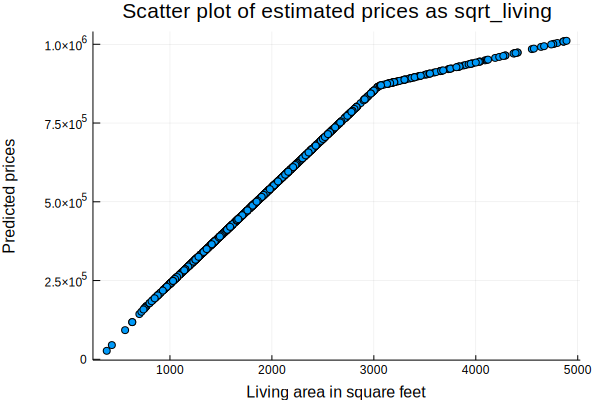

In [17]:
plot_prediction(X_train2, new_X_test2, y_test2, denom_X_train2, mean_X_train2, denom_y_train2, mean_y_train2, θ2, ξ2, "Scatter plot of estimated prices as sqrt_living", "Living area in square feet")

**OBSERVATIONS AND INTERPRETATION FROM THE PLOT**
* The predicted prices of houses increase as the living area increases for areas between 0 and around 3,000 square feet. It seems logical, since the bigger the house, the more expensive it should be.
* However, these prices decrease when the living area increases for areas greater than 3,000 square feet. It can be explained by the **disminishing return** of houses: for very big houses, extra rooms have less value per square feet as they are more rooms in the house.

---

#### (c) Fit a new concave regression model to predict price, using only the variable "lat"

In [18]:
# extract columns price and lat
df3 = df[:, filter(x -> (x in [:price,:lat]), names(df))]

,price,lat
1,221900.0,47.5112
2,538000.0,47.721
3,180000.0,47.7379
4,604000.0,47.5208
5,510000.0,47.6168
6,1.225e6,47.6561
7,257500.0,47.3097
8,291850.0,47.4095
9,229500.0,47.5123
10,323000.0,47.3684



Size of training set:(50, 1)(50,)
Size of test set:(950, 1)(950,)
0.9999999999999998
0.9667230972691053
1.0306876079524465
1.0000000000000002
Academic license - for non-commercial use only

Status: Optimal
Number of iterations: 7
Number of constraints added: 248

***RESULTS***
R2 train:	0.2711101915003511
R2 test:	0.038971322239304884


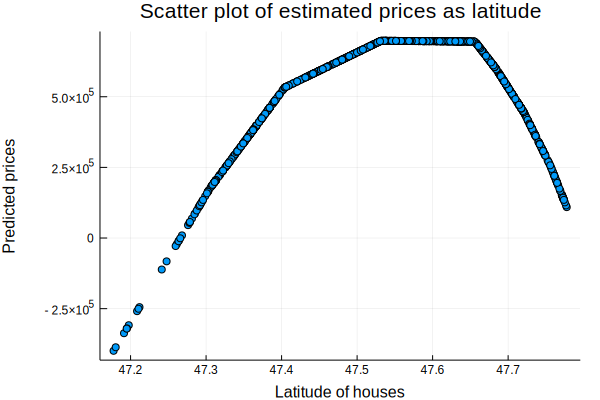

In [19]:
# fitting and predictions
X_train3, y_train3, X_test3, y_test3, denom_X_train3, mean_X_train3, denom_y_train3, mean_y_train3 = normalize(df3, 50, true);
tol = 0.1
θ3, ξ3, iter, constraints = convex_regression(X_train3, -y_train3, tol, true);
out_of_sample(X_train3, y_train3, X_test3, y_test3, θ3, ξ3);

#retrieve lat between 47.16 and 47.78
temp2 = [x for x in X_test3 if x*denom_X_train3[1]+mean_X_train3[1]>=47.16 && x*denom_X_train3[1]+mean_X_train3[1]<=47.78]
new_X_test3 = zeros(Float64, length(temp2), 1)
for i in 1:length(temp2)
    new_X_test3[i] = temp2[i]
end

plot_prediction(X_train3, new_X_test3, y_test3, denom_X_train3, mean_X_train3, denom_y_train3, mean_y_train3, θ3, ξ3, "Scatter plot of estimated prices as latitude", "Latitude of houses")

**OBSERVATIONS FROM THE PLOT**
* The predicted prices of houses increase as the latitude increases between latitudes 47.16 and approximately latitude 47.4
* They continue to increase, but with a lower slope, approximately between latitudes 47.4 and 47.52
* They are at the greatest prices and hit a level where they say constant, approximately between latitudes 47.52 and 47.65
* Finally, they decrease approximately between latitudes 47.65 and 47.78.

**INTERPRETATIONS**
* The houses between approximately between latitudes 47.52 and 47.65 are in the **centre of the city**. Their location is much **more attractive and popular**, so their price much higher than the other houses.
* The other houses are **further from the centre of the city** (maybe in the suburbs), so they are much **less attractive**, so less pricy.

---

#### (d) 

The MIQO introduces sparcity in the optimum $\xi$: it selects only k components. Which makes each constraint $\theta_i + \xi_i^T(x_j - x_i) \leq \theta_j$ much less 'heavy' as we decrease the dimension of $\xi$. So the sparsity makes the MIQO solvable in a linear time $k \times n$. 

In constrast, our convex regression here adds at most n constraints for each block of n constraints at each iterations. So, the problem is solvable in quadratic time $n^2$ in the worst case, and in a more general form $m \times n$ where $m$ could be equal to $n$.